In [1]:
%config Completer.use_jedi = False

import sys
sys.path.append('../../ACORE-LFI/')
sys.path.append('../../ACORE-LFI/acore/')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from toy_data import generate_data, plot_data, plot_vectors
from models.muon_features import MuonFeatures
from acore_ada import ACORE

# Generate and plot toy data

In [3]:
train, test = generate_data(sample_size=1000, test_fraction=0.05, slope=10, precision=3, seed=77)

In [4]:
train.shape, test.shape

((950, 2), (50, 2))

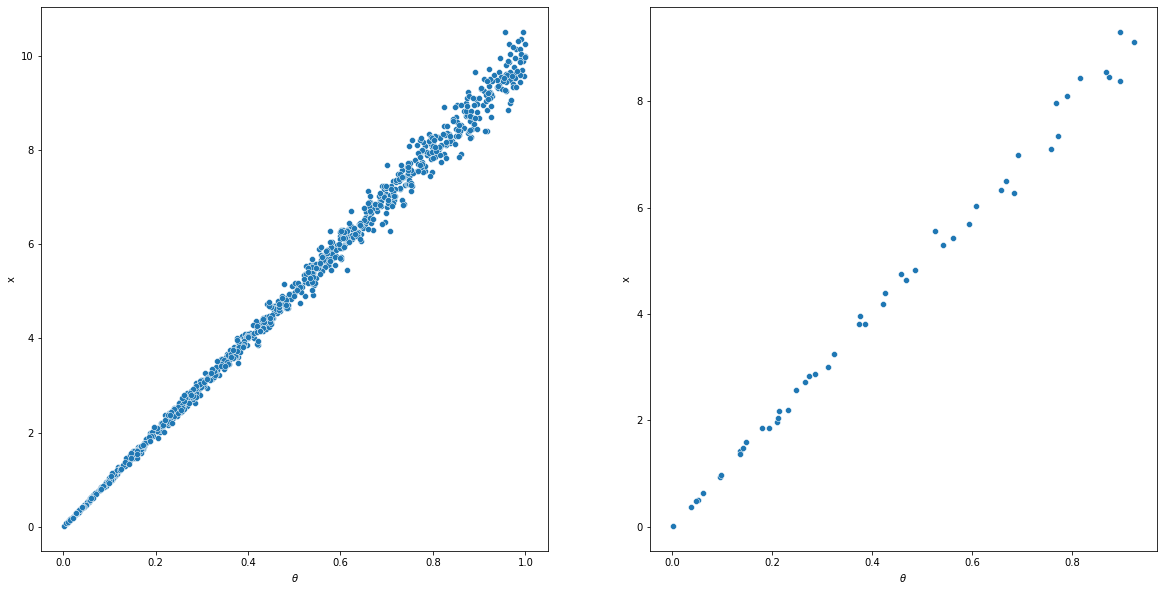

In [5]:
plot_data(train_set=train, test_set=test)

# Construct confidence intervals for $\theta$ with ACORE

In [15]:
data = generate_data(sample_size=10000, test_fraction=0.05, slope=10, precision=3, seed=77, split=False)

In [16]:
model = MuonFeatures(data=data, 
                     t0_grid_granularity=100, 
                     true_param_low=0, 
                     true_param_high=1, 
                     observed_dims=1, 
                     observed_sample_fraction=0.05,
                     reference_g='marginal',
                     param_column=0, 
                     debug=True)

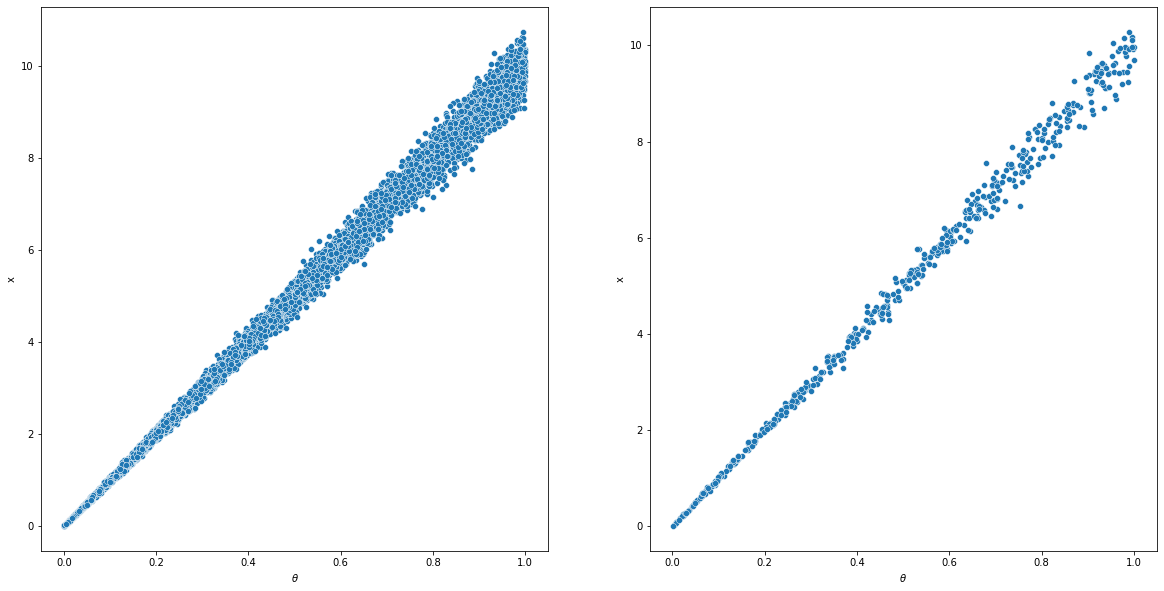

In [17]:
plot_data(train_set=model.train_set, test_set=np.hstack((model.obs_param.reshape(-1, 1),model.obs_x)))

#### Show data for label = 1 and label = 0 (G reference)

In [12]:
try_sample = model.generate_sample(sample_size=10000)

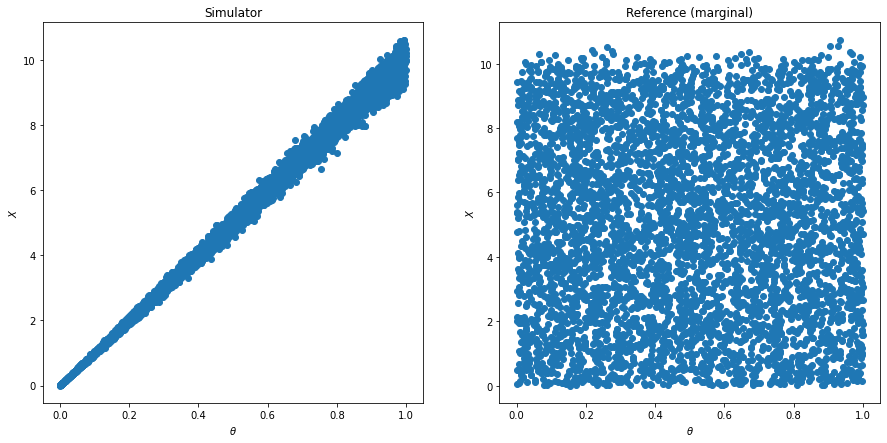

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].scatter(x=try_sample[try_sample[:,0] == 1,1], y=try_sample[try_sample[:,0] == 1,2])
ax[0].set_xlabel(r"$\theta$")
ax[0].set_ylabel(r"$X$")
ax[0].set_title("Simulator")
ax[1].scatter(x=try_sample[try_sample[:,0] == 0,1], y=try_sample[try_sample[:,0] == 0,2])
ax[1].set_title("Reference (marginal)")
ax[1].set_xlabel(r"$\theta$")
ax[1].set_ylabel(r"$X$")
plt.show()

In [19]:
acore = ACORE(model=model, 
              b=1000, 
              b_prime=1000, 
              alpha=0.05, 
              classifier_or='MLP', 
              classifier_qr='xgb_d3_n100', 
              sample_size_obs=1, 
              debug=True)

In [20]:
acore.model.train_set_left.shape, acore.model.train_set.shape, acore.model.obs_x.shape, acore.model.obs_param.shape

((9500, 2), (9500, 2), (500, 1), (500,))

In [21]:
acore.confidence_band()

----- MLP Trained


Calculate Odds: 100%|██████████| 50000/50000 [01:47<00:00, 465.87it/s]

----- Training Quantile Regression Algorithm


----- Creating Confidence Band


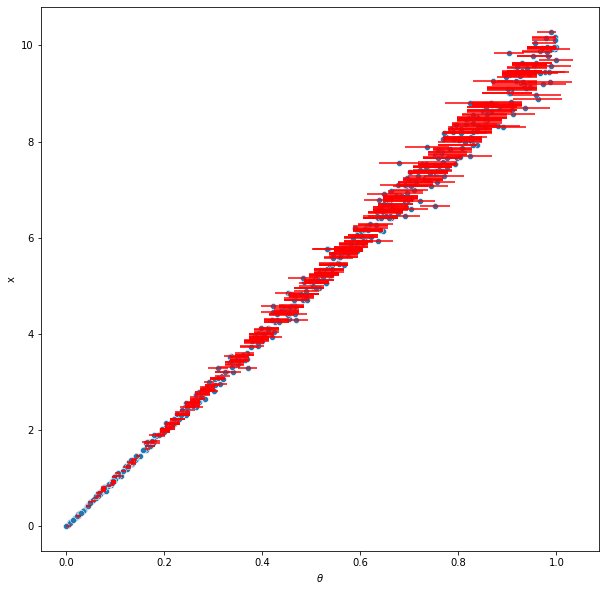

In [22]:
df = acore.plot_confidence_band(return_df=True)

In [23]:
df.uncovered.sum()

98

In [24]:
df.loc[(df.obs_theta <= df.lower) | (df.obs_theta >= df.upper)]

,obs_x,obs_theta,lower,upper,error_bar_center,uncovered,lower_err,upper_err
11,7.689598,0.822893,0.727273,0.818182,0.772727,True,0.045455,0.045455
14,1.235250,0.120945,0.121212,0.131313,0.126263,True,0.005051,0.005051
23,0.349912,0.036421,0.040404,0.040404,0.040404,True,0.000000,0.000000
24,5.935439,0.635962,0.565657,0.626263,0.595960,True,0.030303,0.030303
29,6.767726,0.721462,0.646465,0.707071,0.676768,True,0.030303,0.030303
...,...,...,...,...,...,...,...,...
452,0.287977,0.029359,0.030303,0.030303,0.030303,True,0.000000,0.000000
456,9.244205,0.986668,0.868687,0.959596,0.914141,True,0.045455,0.045455
461,0.688272,0.064779,0.070707,0.070707,0.070707,True,0.000000,0.000000
483,0.694719,0.066037,0.070707,0.080808,0.075758,True,0.005051,0.005051


In [35]:
df.loc[(df.obs_theta - df.upper > 0) & (df.obs_theta - df.lower >),:]

,obs_x,obs_theta,lower,upper,lower_err,upper_err
3,2.833542,0.283945,0.272727,0.292929,0.011217,0.008985
4,4.117233,0.406815,0.393939,0.434343,0.012876,0.027528
5,1.667177,0.170174,0.161616,0.171717,0.008558,0.001543
6,4.490166,0.458997,0.424242,0.474747,0.034755,0.015750
7,1.925401,0.190903,0.181818,0.202020,0.009085,0.011117
...,...,...,...,...,...,...
493,6.858318,0.673455,0.646465,0.717172,0.026990,0.043717
495,9.333808,0.920689,0.888889,0.969697,0.031800,0.049008
496,7.457644,0.740891,0.707071,0.777778,0.033820,0.036887
497,5.044981,0.503920,0.474747,0.525253,0.029172,0.021333


In [36]:
500 

(500, 6)